# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
import numpy as np
import torch
import random
from tqdm import tqdm
from pathlib import Path
import copy
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import kagglehub
from datasets import load_dataset
from Utils import train_w_early_stopping

In [7]:
data_files = {
    "train": "data/mitbih_train.csv",
    "test": "data/mitbih_test.csv"
}

In [8]:
df_train = pd.read_csv(data_files["train"], header=None)

df_test = pd.read_csv(data_files["test"], header=None)

X_train_raw = df_train.iloc[:, :-1].values.astype(np.float32)
y_train = df_train.iloc[:, -1].values.astype(int)
X_test_raw  = df_test.iloc[:, :-1].values.astype(np.float32)
y_test  = df_test.iloc[:, -1].values.astype(int)

In [9]:
print(f"Total ECGs recolectados: {len(df_train) + len(df_test)}")
print(f"Total datos en train: {len(df_train)}")
print(f"Total datos en test: {len(df_test)}")
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts  = pd.Series(y_test).value_counts().sort_index()
print("\n---- Conteo por clase en datos de train----")
print(train_counts)
print("\n---- Conteo por clase en datos de test----")
print(test_counts)
print("\n---- Largo de los segmentos de ECG ----")
print(len(X_train_raw[0]))


Total ECGs recolectados: 109446
Total datos en train: 87554
Total datos en test: 21892

---- Conteo por clase en datos de train----
0    72471
1     2223
2     5788
3      641
4     6431
Name: count, dtype: int64

---- Conteo por clase en datos de test----
0    18118
1      556
2     1448
3      162
4     1608
Name: count, dtype: int64

---- Largo de los segmentos de ECG ----
187


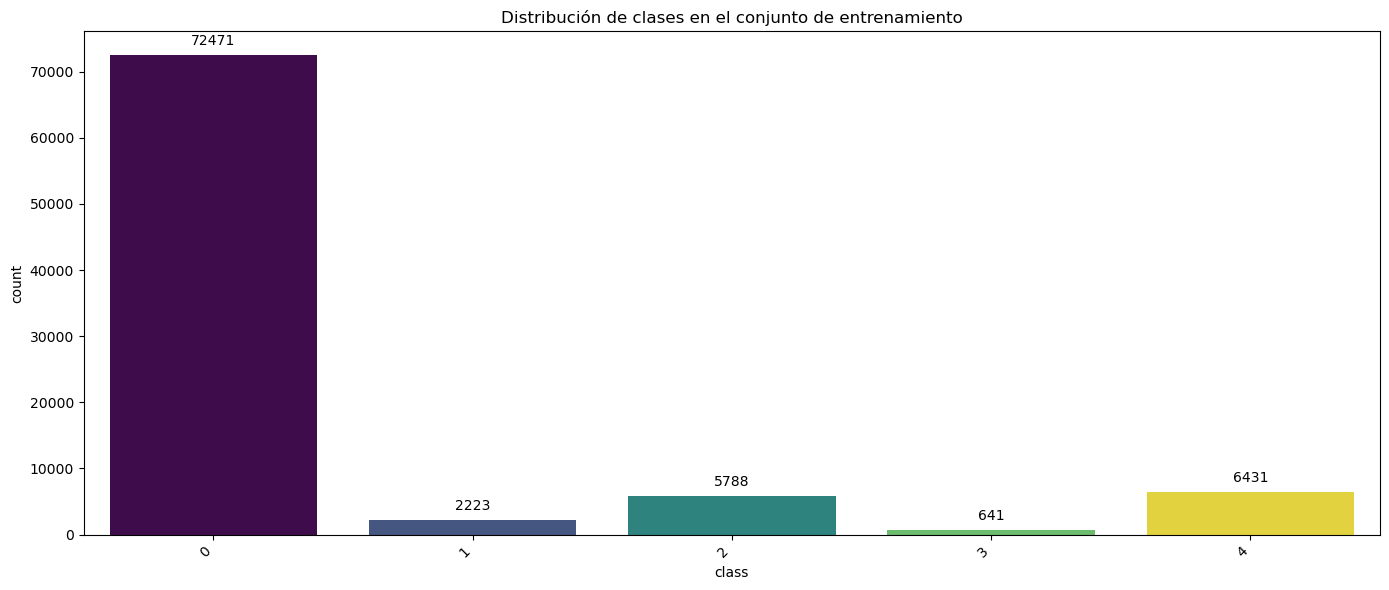

In [10]:
class_counts_train = train_counts.reset_index()
class_counts_train.columns = ["class", "count"]

plt.figure(figsize=(14,6))
ax = sns.barplot(data=class_counts_train, x="class", y="count", hue="class", palette="viridis", legend=False)

plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width()/2., height),
        ha='center', va='bottom',
        fontsize=10,
        xytext=(0, 5), textcoords='offset points'
    )

plt.tight_layout()
plt.show()


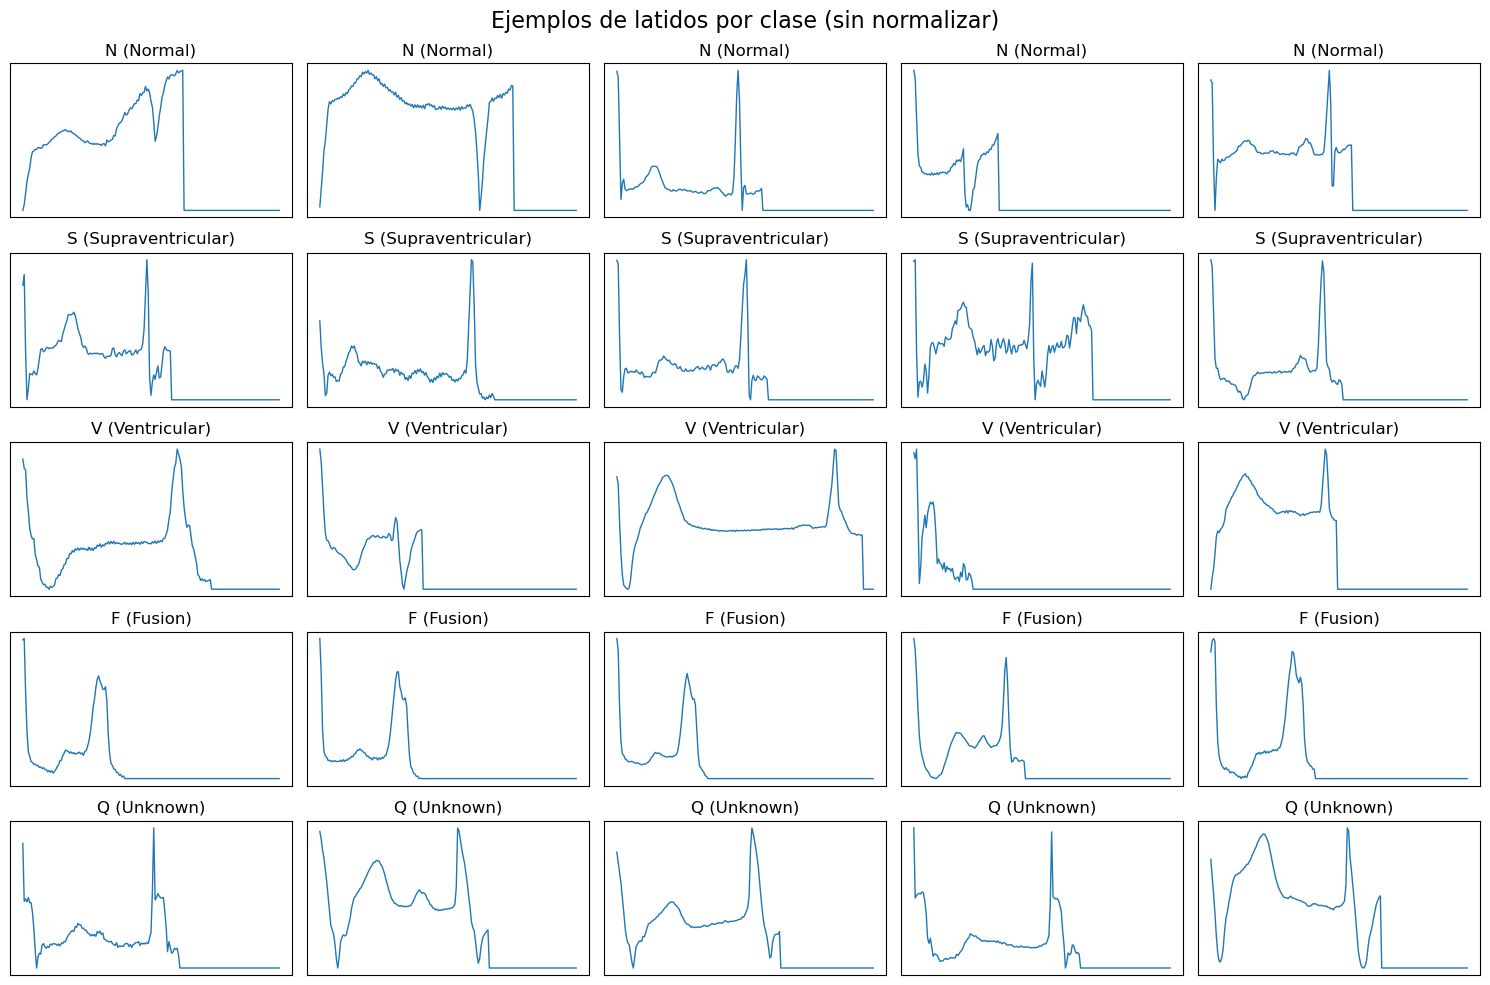

In [ ]:
class_names = {0: "N (Normal)", 1: "S (Supraventricular)", 2: "V (Ventricular)", 3: "F (Fusion)", 4: "Q (Unknown)"}

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 10), sharex=True)

for cls in range(5):
    class_indices = np.where(y_train == cls)[0]
    chosen = np.random.choice(class_indices, size=5, replace=False)

    for i, idx in enumerate(chosen):
        axes[cls, i].plot(X_train_raw[idx], linewidth=1)
        axes[cls, i].set_title(class_names[cls])
        axes[cls, i].set_xticks([])
        axes[cls, i].set_yticks([])

plt.suptitle("Ejemplos de latidos por clase (sin normalizar)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

for cls in range(5):
    class_beats = X_train_raw[y_train == cls]
    mean = class_beats.mean(axis=0)
    std = class_beats.std(axis=0)

    ax.plot(mean, label=f"{class_names[cls]}")
    ax.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)

ax.set_title("Promedio ± desviación estándar por clase")
ax.set_xlabel("Tiempo (muestras)")
ax.set_ylabel("Amplitud")
ax.legend()
plt.show()
